# CMSE 381 Final Project Template

**INSTRUCTIONS**: This is a template to help organize your project.  All projects should include the 5 major sections below (you do not need to use this template file).  If you use this file, complete your work below and remove content in parentheses. Also, remove this current cell.  

#### CMSE 381 Final Project
### &#9989; Group members: NAME1, NAME2
### &#9989; Section_00X
#### &#9989; Date

# ___PROJECT TITLE HERE___

## Background and Motivation

_(Provide context for the problem.  **Clearly state the question(s) you set
out to answer.**)_

## Methodology
_(How did you go about answering your question(s)? You should wrote some code here to demonstrate what the data is like and how in principle your method works. You can leave the variations of the related to specific results to the results section.)_

In [288]:
# you may want to import some modules here

# Data


### General Description
The dataset describes consists of neural activations from a brain region (anterior medial face patch) which is activated when an animal sees a face. The animal views a total of 25 different individuals and 8 different head orientations of each person. A value of 1 means the neuron is active in a specific time interval while 0 means the neuron is not active. 

### Research Question 2:
We consider only one dataset from the zip file named 'Freiwald_Tsao_faceviews_AM_data_csv' for this question. Since our goal is to find what model predicts the individuals correctly, our target variable is 'labels.person' (each person viewed by the animal). The rest of the features are used as predictors ('site_info.monkey', 'site_info.region', 'labels.stimID', 'labels.person', 'labels.orientation'	'labels.orient_person_combo', 'time.1_2',... to ... 'time.399_400'). We only consider upto time.399_400, as only 400ms is relevant for the labeled image. We subsequently introduce new features:
- activations_0_200: total number of activations (1) between 0m/s and 200m/s of viewing the image
- activations_200_400: total number of activations (1) between 200m/s and 400m/s
- total_activations: total number of activation for a trial
- first_activation_time_frame: the first neural activation (1) encountered in a specific trial
- mean_activations: the mean number of activations for a trial

These features were used to capture the time features as a whole. The reason we introduce these features is because we were completely unsure whether the model would capture the data well (without bias) using about 400 columns consisting of many 0s and very minimal activations (1). 

In [292]:
# Packages Used
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [293]:
# Loading and displaying the dataset
directory_path = "Freiwald_Tsao_faceviews_AM_data_csv"
file_list = os.listdir(directory_path)
data_list = []
count = 0
for file_name in file_list:
    file_path = os.path.join(directory_path, file_name)
    if ".csv" in file_path:
        data_temp = pd.read_csv(file_path)
        data_list.append(data_temp)
        count += 1
    if count == 1:
        break
data = pd.concat(data_list)
print(data.shape)
data.head()

(1600, 806)


,site_info.monkey,site_info.region,labels.stimID,labels.person,labels.orientation,labels.orient_person_combo,time.1_2,time.2_3,time.3_4,time.4_5,...,time.791_792,time.792_793,time.793_794,time.794_795,time.795_796,time.796_797,time.797_798,time.798_799,time.799_800,time.800_801
0,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bert,am,1,1,front,front 1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [294]:
data = data.iloc[:, :405] 
data = data.drop(['site_info.region'], axis=1)

In [295]:
time_data = data.iloc[:, 5:]
time_cols = list(data.columns)[5:]

data['activations_0_200'] = data.iloc[:, 5:205].sum(axis=1)
data['activations_200_400'] = data.iloc[:, 205:405].sum(axis=1)
data['total_activations'] = data.iloc[:, 5:405].sum(axis=1)

first_activations = []
for i, row in data.iterrows():
    first_act_col = None
    for col in time_cols:
        if row[col] == 1:
            first_act_col = col
            break
        else:
            first_act_col = 'None'
    first_activations.append(first_act_col)
data['first_activation_time_frame'] = first_activations

data['mean_activations'] = data['total_activations'] / len(time_cols)
data.head()

,site_info.monkey,labels.stimID,labels.person,labels.orientation,labels.orient_person_combo,time.1_2,time.2_3,time.3_4,time.4_5,time.5_6,...,time.395_396,time.396_397,time.397_398,time.398_399,time.399_400,activations_0_200,activations_200_400,total_activations,first_activation_time_frame,mean_activations
0,bert,1,1,front,front 1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,0.000000
1,bert,1,1,front,front 1,0,0,0,0,0,...,0,0,0,0,0,1,1,2,time.157_158,0.005013
2,bert,1,1,front,front 1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,time.369_370,0.002506
3,bert,1,1,front,front 1,0,0,0,0,0,...,0,0,0,0,0,1,1,2,time.165_166,0.005013
4,bert,1,1,front,front 1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,0.000000


In [296]:
label_encoder = LabelEncoder()
data = data.apply(label_encoder.fit_transform)
data.head()

,site_info.monkey,labels.stimID,labels.person,labels.orientation,labels.orient_person_combo,time.1_2,time.2_3,time.3_4,time.4_5,time.5_6,...,time.395_396,time.396_397,time.397_398,time.398_399,time.399_400,activations_0_200,activations_200_400,total_activations,first_activation_time_frame,mean_activations
0,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,1,1,2,59,2
2,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,0,1,1,215,1
3,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,1,1,2,68,2
4,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Models for classification _(if applicable)_
_(What models will you be using for classification? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

In [298]:
# you may add some code here to show how the model works in principle

### Research Question 2: Models for a regression/ a very different classification _(if applicable)_

The models we used for this research question are:
- Logistic Regression: The baseline for a classification task
- KNN (K-Nearest Neighbors): 
- Random Forest:
- AdaBoost: 

We aim to capture the best model and in doing so also capture the best hyperparameter of the best model that predicts our target variable. 

### Steps:
1. Using simple training and testing, evaluate the models based on their accuracies using all the features.
2. Use all the features to perform K-Fold cross-validation to get the best accuracies and k (fold value) across all models
3. Use only the newly introduced features (activations_0_200, activations_200_400, total_activations, first_activation_time_frame, mean_activations) and repeat step 1.
4. Using the features from step 3, repeat step 2. 
5. Use PCA (Principal Component Analysis) to reduce the number of features to 10 and evaluate the models based on accuracies. 
6. Use K-Fold to obtain the best number of components and obtain the accuracies of the models along with the optimal number of components.
7. Compare the results obtained across step 1 - step 6
8. Using the best model obtained through accuracies, find the best hyperparameter for that model and evaluate results.

In [300]:
# you may add some code here to show how the model works in principle


### Other methods used _(if applicable)_

_(If this is a preprocessing step to prepare your data for regression or classification models, you should put this subsection before your explanation for the regression or classification models.)_

_(What method did you use otherwise? Why did you choose to use them? What questions would you answer with them? How would you evaluate the results? What cross-validation method did you use when applicable?)_

In [302]:
# you may add some code here to show how the method works in principle

### Research Question 2: Preprocessing

In [304]:
label_encoder = LabelEncoder()
data = data.apply(label_encoder.fit_transform)
data.head()

,site_info.monkey,labels.stimID,labels.person,labels.orientation,labels.orient_person_combo,time.1_2,time.2_3,time.3_4,time.4_5,time.5_6,...,time.395_396,time.396_397,time.397_398,time.398_399,time.399_400,activations_0_200,activations_200_400,total_activations,first_activation_time_frame,mean_activations
0,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,1,1,2,59,2
2,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,0,1,1,215,1
3,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,1,1,2,68,2
4,0,0,0,2,50,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# you may add some code here to show how the model works in principle

## Results

_(What did you find when you carried out your methods? Some of your code related to
presenting results/figures/data may be replicated from the methods section or may only be present in
this section. All of the plots that you plan on using for your presentation should be present in this
section)_

### classification results
_(What are you trying to do here?)_

In [309]:
# how did you do it

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [311]:
# how did you do it (etc. etc.)

### regression results


In [313]:
# how did you do it


### Research Question 2: classification results

#### Helper functions
These functions perform:
- training and testing for different models
- kfold to obtain best accuracies and k values for different models
- kfold to obtain best accuracies and number of components for PCA for different models

In [316]:
### Helper Functions ###
def train_test(models, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10)

    results = {}
    for i, model in models.items():
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        results[i] = acc

    return results

def perform_KFold(model, X_values, y_values):
    best_acc = -float('inf')
    optimal_k = None  
    acc_lst = []
    
    for i in range(2, 15):  
        kf = KFold(n_splits=i, shuffle=True, random_state=10)
        accs = []
        for train_idx, test_idx in kf.split(X_values):
            X_train, X_test = X_values[train_idx], X_values[test_idx]
            y_train, y_test = y_values[train_idx], y_values[test_idx]
            
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            acc = accuracy_score(y_test, y_hat)
            accs.append(acc)
            
        avg_acc = np.mean(accs)
        acc_lst.append(avg_acc)
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            optimal_k = i

    plt.plot(range(2, 15), acc_lst, marker='o')
    plt.xlabel('Fold (k)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Folds')
    plt.grid(True)
    plt.show()

    return best_acc, optimal_k

def perform_KFold_PCA(model, X_values, y_values, optimal_k):    
    best_acc = -float('inf')
    optimal_n = None
    acc_lst = []
    
    n_lst = [10, 30, 50, 100, 200]
    
    for n in n_lst:
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(X_values)
        kf = KFold(n_splits=optimal_k, shuffle=True, random_state=4)
        accs = []
        
        for train_idx, test_idx in kf.split(X_pca):
            X_train, X_test = X_pca[train_idx], X_pca[test_idx]
            y_train, y_test = y_values[train_idx], y_values[test_idx]
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            acc = accuracy_score(y_test, y_hat)
            accs.append(acc)
            
        avg_acc = np.mean(accs)
        acc_lst.append(avg_acc)
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            optimal_n = n
    
    plt.plot(n_lst, acc_lst, marker='o')
    plt.xlabel('number of components')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Components')
    plt.grid(True)
    plt.show()
    
    return best_acc, optimal_n


def perform_KFold(model, X_values, y_values):
    best_acc = -float('inf')
    optimal_k = None  
    acc_lst = []
    
    for i in range(2, 15):  
        kf = KFold(n_splits=i, shuffle=True, random_state=10)
        accs = []
        for train_idx, test_idx in kf.split(X_values):
            X_train, X_test = X_values[train_idx], X_values[test_idx]
            y_train, y_test = y_values[train_idx], y_values[test_idx]
            
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            acc = accuracy_score(y_test, y_hat)
            accs.append(acc)
            
        avg_acc = np.mean(accs)
        acc_lst.append(avg_acc)
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            optimal_k = i

    plt.plot(range(2, 15), acc_lst, marker='o')
    plt.xlabel('Fold (k)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Folds')
    plt.grid(True)
    plt.show()

    return best_acc, optimal_k

# def perform_LOOCV(model, X_values, y_values):
#     best_acc = -float('inf')
#     optimal_k = None  
#     acc_lst = []
    
#     for i in range(2, 15):  
#         kf = KFold(n_splits=i, shuffle=True, random_state=10)
#         accs = []
#         for train_idx, test_idx in kf.split(X_values):
#             X_train, X_test = X_values[train_idx], X_values[test_idx]
#             y_train, y_test = y_values[train_idx], y_values[test_idx]
            
#             model.fit(X_train, y_train)
#             y_hat = model.predict(X_test)
            
#             acc = accuracy_score(y_test, y_hat)
#             accs.append(acc)
            
#         avg_acc = np.mean(accs)
#         acc_lst.append(avg_acc)
        
#         if avg_acc > best_acc:
#             best_acc = avg_acc
#             optimal_k = i

#     plt.plot(range(2, 15), acc_lst, marker='o')
#     plt.xlabel('Fold (k)')
#     plt.ylabel('Accuracy')
#     plt.title('Accuracy vs Number of Folds')
#     plt.grid(True)
#     plt.show()

#     return best_acc, optimal_r

### Performing Analysis

In [318]:
# Step 1 Using simple training and testing, evaluate the models based on their accuracies using all the features.
y = data['labels.person']
X = data.drop(['labels.person'], axis=1)

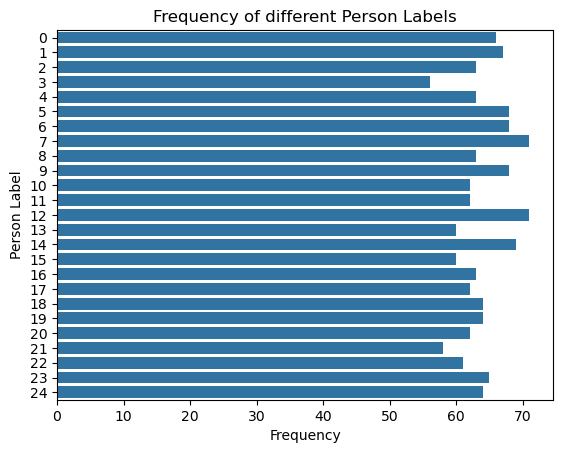

In [319]:
sns.countplot(y=y)
plt.title('Frequency of different Person Labels')
plt.xlabel('Frequency')
plt.ylabel('Person Label')
plt.show()

The above shows how the labels of different individuals (column 'labels.person') are distributed across the dataset. Person label 7 shows up the most in the dataset followed by 12, 14 and 1 and so on...

In [321]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = {'Logistic Regression': LogisticRegression(max_iter=1000), 'KNN': KNeighborsClassifier(n_neighbors=1),
          'Random Forest': RandomForestClassifier(random_state=10),'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=10,
                                                                                                 algorithm="SAMME")}

results = train_test(models, X, y)
print(f'Accuracies (all features) using different models:\n {results}')

Accuracies (all features) using different models:
 {'Logistic Regression': 0.06875, 'KNN': 0.709375, 'Random Forest': 0.690625, 'AdaBoost': 0.10625}


KNN shows the best accuracy when simple training and testing is performed using all features


-----------Using Logistic Regression for KFold----------


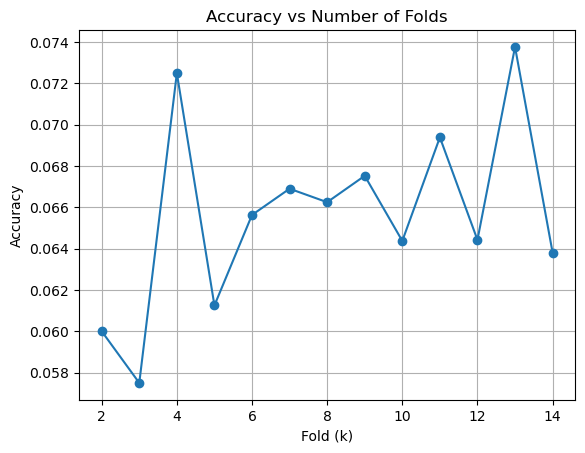


-----------Using KNN for KFold----------


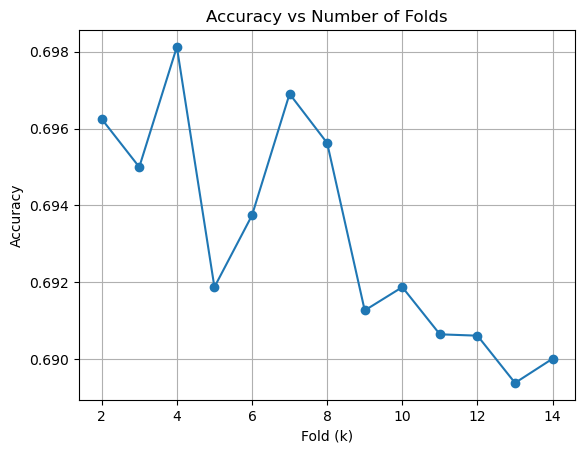


-----------Using Random Forest for KFold----------


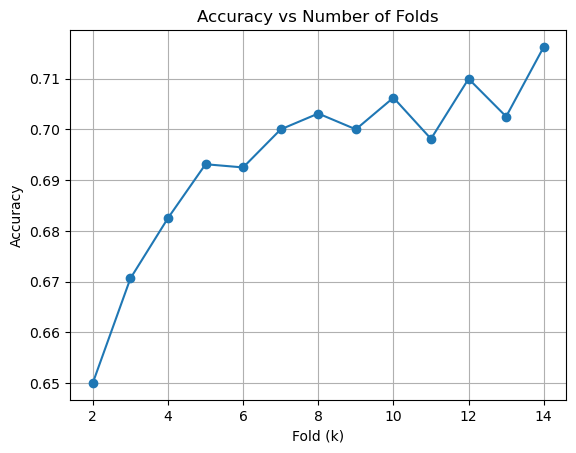


-----------Using AdaBoost for KFold----------


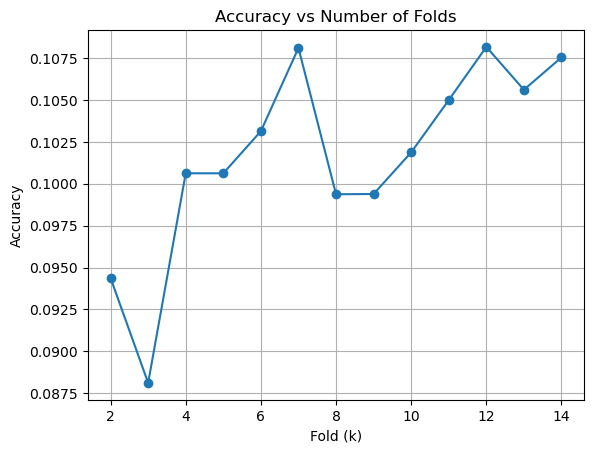

In [323]:
# Step 2 Use all the features to perform K-Fold cross-validation to get the best accuracies and k (fold value) across all models
results_cv = {}
for i, model in models.items():
    print(f'\n-----------Using {i} for KFold----------')
    best_acc, optimal_k = perform_KFold(model, X_scaled, y.values)
    results_cv[i] = (best_acc, optimal_k)

In [324]:
print(f' Best Accuracy and k values of models: results:\n {results_cv}')

 Best Accuracy and k values of models: results:
 {'Logistic Regression': (0.07377090520284856, 13), 'KNN': (0.6981249999999999, 4), 'Random Forest': (0.7162580363953361, 14), 'AdaBoost': (0.10816687240489282, 12)}


Random Forest shows the best accuracy after K-Fold cross validation is performed using all features

In [326]:
# Step 3 Use only the newly introduced features (activations_0_200, activations_200_400, total_activations, first_activation_time_frame, mean_activations) and repeat step 1.
y = data['labels.person']
X_selected = data.drop(data.iloc[:, 5:406], axis=1)

In [327]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

models = {'Logistic Regression': LogisticRegression(max_iter=1000), 'KNN': KNeighborsClassifier(n_neighbors=1),
          'Random Forest': RandomForestClassifier(random_state=10),'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=10,
                                                                                                 algorithm="SAMME")}

results_selected = train_test(models, X_selected, y)
print(f'Accuracies (all features) using different models:\n {results_selected}')

Accuracies (all features) using different models:
 {'Logistic Regression': 0.359375, 'KNN': 0.753125, 'Random Forest': 0.928125, 'AdaBoost': 0.171875}


Random Forest shows the best accuracy when simple training and testing is performed using the newly introduced features


-----------Using Logistic Regression for KFold----------


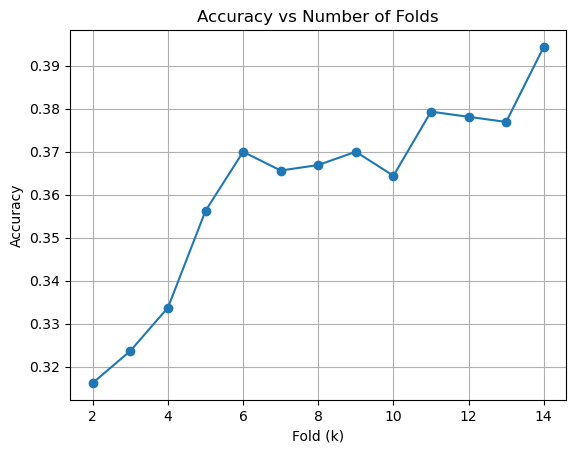


-----------Using KNN for KFold----------


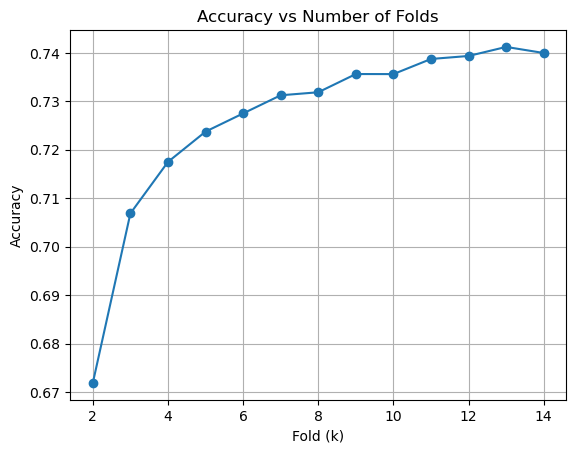


-----------Using Random Forest for KFold----------


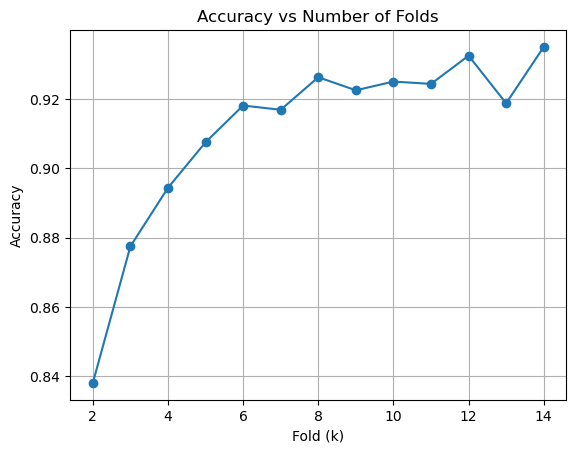


-----------Using AdaBoost for KFold----------


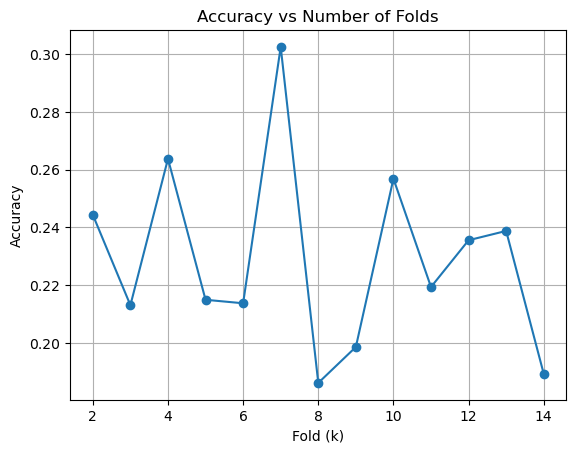

In [329]:
# Step 4 Using the features from step 3, repeat step 2. 
results_selected_cv = {}
for i, model in models.items():
    print(f'\n-----------Using {i} for KFold----------')
    best_acc, optimal_k = perform_KFold(model, X_scaled, y.values)
    results_selected_cv[i] = (best_acc, optimal_k)

In [330]:
print(f' Best Accuracy and k values of models: results:\n {results_selected_cv}')

 Best Accuracy and k values of models: results:
 {'Logistic Regression': (0.3943173150266972, 14), 'KNN': (0.741234440880389, 13), 'Random Forest': (0.9349841996295085, 14), 'AdaBoost': (0.3024373159974171, 7)}


Random Forest shows the best accuracy after K-Fold cross validation is performed using the selected features

In [332]:
# Step 5 Use PCA (Principal Component Analysis) to reduce the number of features to 10 and evaluate the models based on accuracies. 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reduced_scaled = scaler.fit_transform(X_scaled)

pca = PCA(n_components=10)  
X_pca = pca.fit_transform(X_scaled)
print(f'Features reduced from {X.shape[1]} to {X_pca.shape[1]}')

results_pca = train_test(models, X_pca, y)
print(f'Accuracies (PCA) using different models:\n {results_pca}')

Features reduced from 408 to 10
Accuracies (PCA) using different models:
 {'Logistic Regression': 0.06875, 'KNN': 0.709375, 'Random Forest': 0.690625, 'AdaBoost': 0.10625}


KNN shows the best accuracy when simple training and testing is performed using the features selected by PCA.


-----------Using Logistic Regression for KFold----------


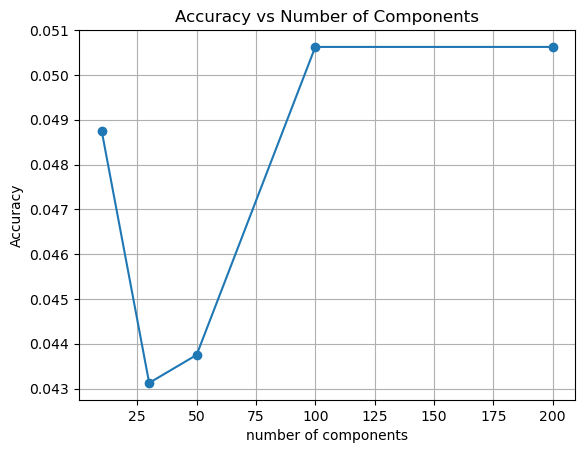


-----------Using KNN for KFold----------


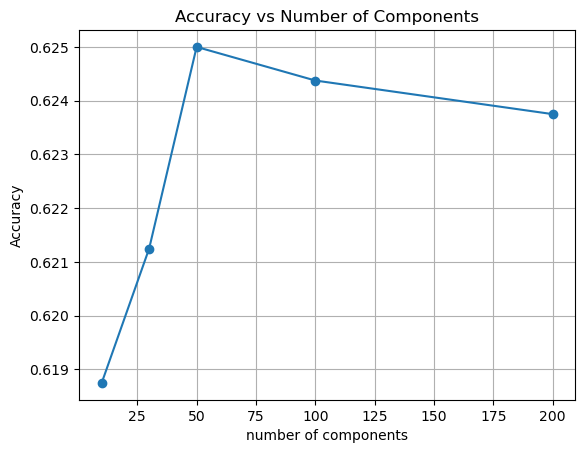


-----------Using Random Forest for KFold----------


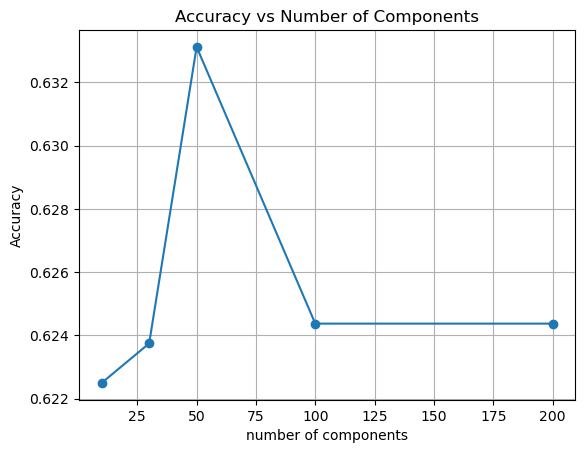


-----------Using AdaBoost for KFold----------


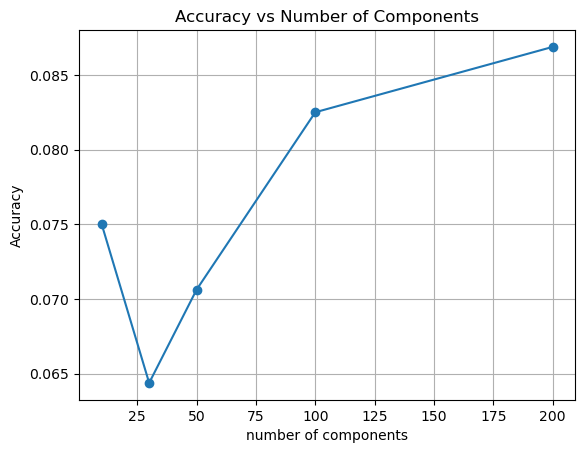

In [334]:
# Step 6 Use K-Fold to obtain the best number of components and obtain the accuracies of the models along with 
# the optimal number of components.
results_pca_cv = {}
for i, model in models.items():
    print(f'\n-----------Using {i} for KFold----------')
    best_acc, optimal_n = perform_KFold_PCA(model, X_scaled, y.values, 5)
    results_pca_cv[i] = (best_acc, optimal_n)

In [335]:
print(f' Best Accuracy and k values of models: results:\n {results_pca_cv}')

 Best Accuracy and k values of models: results:
 {'Logistic Regression': (0.05062500000000001, 100), 'KNN': (0.625, 50), 'Random Forest': (0.6331249999999999, 50), 'AdaBoost': (0.08687500000000001, 200)}


Random Forest shows the best accuracy after K-Fold cross validation is performed using the PCA features

In [400]:
# Step 7 Compare the results obtained across step 1 - step 6
model_names = []
no_pca_accs = []
no_pca_cv_accs = []

pca_accs = []
pca_cv_accs = []

selected_accs = []
selected_cv_accs = []

for i, res in results.items():
    model_names.append(i)
    no_pca_accs.append(res)
    
for i, res in results_cv.items():
    no_pca_cv_accs.append(res[0])

for i, res in results_pca.items():
    pca_accs.append(res)

for i, res in results_pca_cv.items():
    pca_cv_accs.append(res[0])

for i, res in results_selected.items():
    selected_accs.append(res)

for i, res in results_selected_cv.items():
    selected_cv_accs.append(res[0])
    
temp_df = pd.DataFrame({'Model Name': model_names, 'No PCA': no_pca_accs, 'No PCA CV': no_pca_cv_accs,
                        'Selected Features': selected_accs, 'Selected Features CV': selected_cv_accs,
                        'PCA (n=10)': pca_accs, 'PCA CV (best n)': pca_cv_accs})
temp_df

,Model Name,No PCA,No PCA CV,Selected Features,Selected Features CV,PCA (n=10),PCA CV (best n)
0,Logistic Regression,0.068750,0.073771,0.359375,0.394317,0.068750,0.050625
1,KNN,0.709375,0.698125,0.753125,0.741234,0.709375,0.625000
2,Random Forest,0.690625,0.716258,0.928125,0.934984,0.690625,0.633125
3,AdaBoost,0.106250,0.108167,0.171875,0.302437,0.106250,0.086875


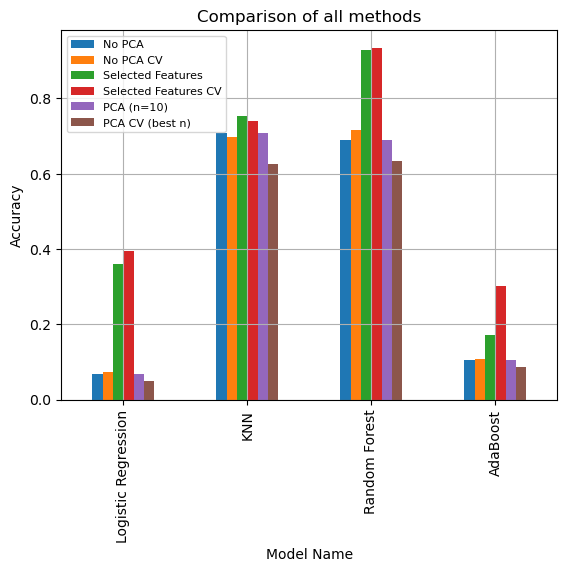

In [338]:
temp_df.plot(kind='bar', x='Model Name')
plt.ylabel('Accuracy')
plt.title('Comparison of all methods')
plt.grid(True)
plt.legend(fontsize=8, loc='upper left')
plt.show()

The graph shows three things:
- Performing cross-validation with selected features almost always performs better than the other methods
- Random forest and KNN are superior to logistic regressiona and AdaBoost
- Cross-validating the random forest model using K-Fold using selected features performs the best out of every other model and method.

In [340]:
# Step 8 Using the best model obtained through accuracies, 
# find the best hyperparameter for that model and evaluate results.
# Random Forest is deemed the best model the best accuracy using the the newly created features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=10)

param_grid = {'n_estimators': [10, 30, 50, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [None, 10, 20, 30, 50],
              'min_impurity_decrease': [0.0, 0.01, 0.1, 0.5], 
             }

grid = GridSearchCV(models['Random Forest'], param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print(f'Best Parameters are {grid.best_params_}')

best_model = grid.best_estimator_

y_hat = best_model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
print(f'Accuracy: {acc}')
print(f'Classification report: \n: {classification_report(y_test, y_hat)}')

Best Parameters are {'criterion': 'entropy', 'max_depth': 20, 'min_impurity_decrease': 0.0, 'n_estimators': 100}
Accuracy: 0.9375
Classification report: 
:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         7
           3       0.92      1.00      0.96        12
           4       1.00      0.95      0.97        20
           5       1.00      1.00      1.00         9
           6       0.89      1.00      0.94         8
           7       0.75      0.92      0.83        13
           8       1.00      0.75      0.86        16
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        12
          12       0.92      1.00      0.96        24
          13       1.00      0.85      0.92        13
          14       0.76      1.00

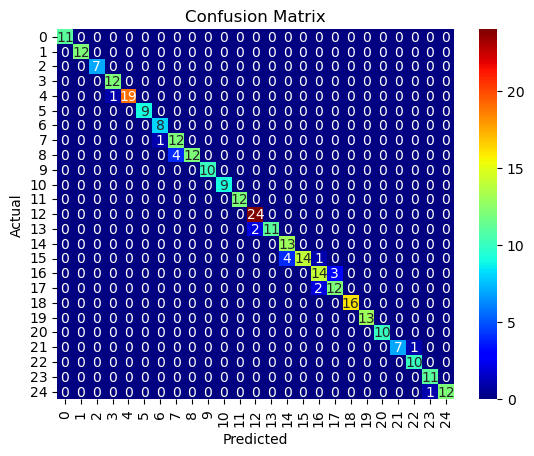

In [341]:
sns.heatmap(confusion_matrix(y_test, y_hat), cmap='jet', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We obtain an accuracy of 93.75% using the best hyperparameters obtained for Random Forest. 
The heatmap shows a good amount of correct classifications for all 25 labels.person (0-24).
Person label 12 shows the most correct classifications followed by label 4 and 17.

### other results
_(What are you trying to do here?)_

In [344]:
# how did you do it


_(How do you interpret what you see?)_

_(What are you doing next?)_

In [346]:
# how did you do it (etc. etc.)

## Discussion and Conclusion

_(What did you learn from your results? What obstacles did you run into? What would you do differently next time? Clearly provide quantitative answers to your question(s)?  At least one of your questions should be answered with numbers.  That is, it is not sufficient to answer "yes" or "no", but rather to say something quantitative such as variable 1 increased roughly 10% for every 1 year increase in variable 2.)_

### discussion on the classification results

### Research Question 2: discussion on the classfication result
We obtain an accuracy of 93.75% using the best hyperparameters obtained for Random Forest. The heatmap shows a good amount of correct classifications for all 25 labels.person (0-24). Person label 12 shows the most correct classifications followed by label 4 and 17. Cross-validation on Random Forest using added features model performs significantly better than all other methods (for random forest) and models. Specifically, it shows a slight improvement on simple training and testing Random forest using added features by ~0.0068% and shows a significant improvement on the other methods used on Random Forest, and the methods used on KNN by ~20-25%. We believe it shows better accuracies (no CV and CV) using the added features as it helps create a more generalized representation across the 400 time features. The time features are binary (0 or 1), and in most cases consist of 0s (non neural activations). By using techniques like capturing the total activations (across the time period and at time intervals) along with the mean activations for each trial, we provide a better overview and hence are able deduce that these features are significant predictors for the target variable 'labels.person'.

#### Conclusions and Future Steps
Research Question 2: We utilized just one csv file (1600, 806) which was subsequently reduced to (1600, 409). Unfortunately the code takes 
~2-3 minutes to complete. We hope to optimize our code, specifically the cross-validation part, which performs poorly (in terms of computational efficiency) when its performed on Random Forest and AdaBoost. Making better additional features to capture the time features and making use of more models (Neural Networks, SVCs) may lead us to obtaining a better model and results.

## Author contribution


Sukruth Rao worked on research question 2 and contributed to the slides, project template, and video

## References

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. **Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for you project.)_

Freiwald, W. A., & Tsao, D. Y. (2010). Functional compartmentalization and viewpoint generalization within the macaque face-processing system. Science, 330(6005), 845-851.

https://medium.com/data-science/adaboost-classifier-explained-a-visual-guide-with-code-examples-fc0f25326d7b#:~:text=AdaBoost%20is%20an%20ensemble%20machine,importance%20to%20previously%20misclassified%20examples.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/